<a href="https://colab.research.google.com/github/Mobad225/Binary-Classification-And-Evaluation/blob/master/Binary_Classification_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
import numpy as np

X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

#Since labels are chars, I will change them to ints
y = y.astype(np.uint8)

(70000, 784) (70000,)


## Visualizing a random photo and its label

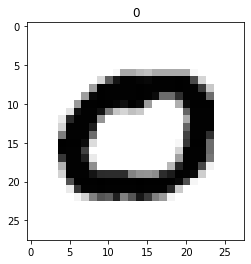

In [5]:
from random import randint
import matplotlib.pyplot as plt

ind = randint(0, X.shape[0] - 1)
digit, digit_label = X[ind], y[ind]

digit_image = digit.reshape(28, 28)

plt.imshow(digit_image, cmap = 'binary')
plt.title(digit_label)
plt.show()

# Split test/train sets
## This dataset is already split 60k train + 10k test

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## I will train a binary classifier that classifies 8 vs other numbers (OvR)

In [0]:
#New labels
y_train_8 = (y_train == 8)
y_test_8 = (y_test == 8)

In [8]:
#Will use SGD classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 22)
sgd_clf.fit(X_train, y_train_8)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=22, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Lets check if the classifier thinks the above digit is an 8!

In [9]:
sgd_clf.predict([digit])
#Looks good in this run :)

array([False])

# Will check the performance measures of this classifier

### First Ill use cross validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv = 3, scoring = 'accuracy')

array([0.94535, 0.9338 , 0.92845])

### Looks good but actually a random classifier would get 90%, I will first check the confusion matrix

In [0]:
from sklearn.model_selection import cross_val_predict

predictions_8 = cross_val_predict(sgd_clf, X_train, y_train_8, cv = 3)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_8, predictions_8)

array([[52280,  1869],
       [ 1979,  3872]])

### And check the F1 score (Gives an idea about both precision & recall)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_8, predictions_8)
#Obviously now, Its not as good as ~93% of the usual cross validation

0.6680469289164942

# Precision/Recall Tradeoff
### Will use plots to visualize it

In [0]:
#To draw Precision/Recall vs threshold, I first need the scores not predictions

predictions_8 = cross_val_predict(sgd_clf, X_train, y_train_8, cv = 3, method= 'decision_function')

In [0]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_train_8, predictions_8)

def plot_prec_recall_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
  plt.legend()
  plt.rcParams["figure.figsize"] = (8,6)
  plt.xlabel('Threshold')

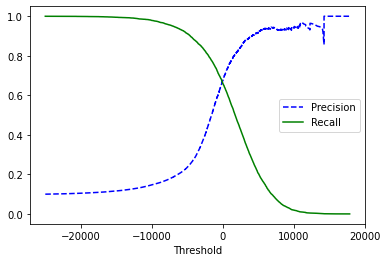

In [16]:
plot_prec_recall_threshold(prec, rec, thresholds)
plt.show()

Or draw directly Precision vs Recall

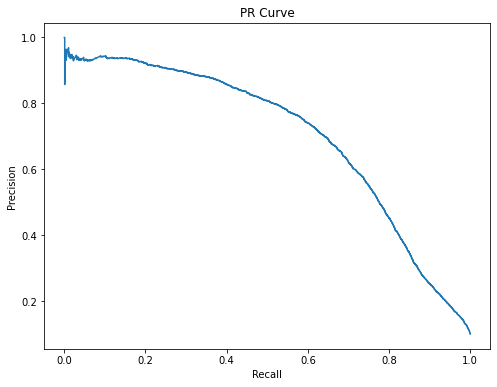

In [17]:
plt.plot(rec[:-1], prec[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.show()

## Lets make the model precision >= 90%!!!

In [18]:
#Choose the precision where accuracy >= 90%

threshold_90_precision = thresholds[np.argmax(prec >= 0.90)]
#np.argmax returns only first occurence of a 1

print(threshold_90_precision)

4107.575389829886


In [0]:
#Since I have the score array, will use my specified threshold.

y_train_pred_90 = (predictions_8 >= threshold_90_precision)
#These are my new labels!

### I will make sure precision >= 90% and check the recall...

In [20]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

prec_score = precision_score(y_train_8, y_train_pred_90)
rec_score = recall_score(y_train_8, y_train_pred_90)

print('Precision = ', prec_score)
print('Recall = ', rec_score)
#OUCH
#Thats the Precision Recall Tradeoff

Precision =  0.9000555247084953
Recall =  0.27704665869082207


## Plotting the ROC Curve (Receiver Operating Characteristic)
### It plots True positive ratio against False positive ratio

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_8, predictions_8)

def plot_roc_curve(fpr, tpr, thresholds, label = None):
  plt.plot(fpr, tpr, label = label)
  plt.xlabel('False Positive Ratio')
  plt.ylabel('True Positive Ratio (Recall)')
  plt.title('ROC Curve')
  if label is not None:
    plt.legend()
  plt.show()

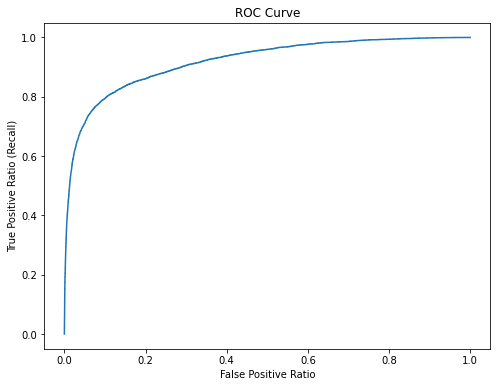

In [22]:
plot_roc_curve(fpr, tpr, thresholds)

In [23]:
#For ROC, The more the AUC, the better.

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_8, predictions_8)

0.9189876516337611

## Will Try a Random Forest Classifier and compare ROC

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 22)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_8, cv = 3, 
                                    method = 'predict_proba')

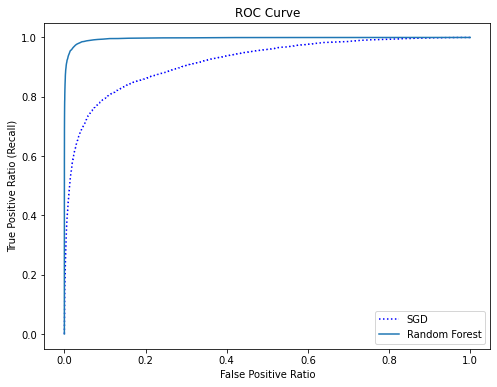

In [25]:
#The ROC Curve expects labels && ( scores || probabilities )

y_scores_forest = y_probas_forest[:, 1] #Defined score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, thresholds_forest, 'Random Forest')

In [26]:
#Interesting!!! Will compare AUC
forest_auc = roc_auc_score(y_train_8, y_scores_forest)
sgd_auc = roc_auc_score(y_train_8, predictions_8)
print(forest_auc, sgd_auc, sep = '\n')

0.9966988562695931
0.9189876516337611


## Finally Ill check confusion matrix for Random Forest Classifier

In [27]:
forest_pred = cross_val_predict(forest_clf, X_train, y_train_8, cv = 3)
confusion_matrix(y_train_8, forest_pred)

array([[54091,    58],
       [ 1125,  4726]])